### Imports

In [1]:
from lavis.models import model_zoo, load_model_and_preprocess
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import cv2
import pytesseract
from manga_ocr import MangaOcr
from transformers import pipeline, AutoModelForSeq2SeqLM, AutoTokenizer
import pyuac
import importlib
import sys
from openai import OpenAI
import openai
import pandas as pd
import time
import deepl

print(model_zoo)

# load captioning model. 
# To change to your customized weights, change pretrained attribute in BLIP2-Japanese\lavis\configs\models\blip2\blip2_pretrain.yaml
caption_model, visual_encoder, text_encoder = load_model_and_preprocess('blip2_Japanese', 'finetune') #load_model_and_preprocess('blip2_Japanese', 'pretrain')

# class for dataset 
class SampleDataset(Dataset):

    def __init__(self, img_root, visual_processor) -> None:
        super().__init__()
        self.img_root = img_root
        self.imgs = os.listdir(img_root)
        self.visual_processor = visual_processor

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, index):
        image_name = self.imgs[index]
        image_path = os.path.join(self.img_root, image_name)
        raw_image = Image.open(image_path).convert("RGB")
        image = self.visual_processor(raw_image)

        return { "image" : image.unsqueeze(0), "name": image_name, "raw": raw_image}

c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Architectures                  Types
blip_pretrain                  base
blip2_Japanese_feature_extractor pretrain, finetune
blip2_Japanese                 pretrain, finetune


## Thesis Code

#### ChatGPT Set Up

In [2]:
# API Key stored in a different file
from openai_api_key import chatgpt_api_key
# Init ChatGPT
openai.api_key = chatgpt_api_key
api_constraints = 20
def get_completion(prompt, model="gpt-3.5-turbo"):

    messages = [{"role": "user", "content": prompt}]

    # response = openai.ChatCompletion.create(model=model, messages=messages, temperature=0,)
    
    completion = openai.chat.completions.create(model=model, messages=messages)

    return completion.choices[0].message.content

#### DeepL SetUp

In [2]:
# API Key stored in a different file
from deepl_api_key import deepl_api_key
deepl_translator = deepl.Translator(deepl_api_key)

def deepl_translate(text: str):
    result = deepl_translator.translate_text(text, source_lang="JA", target_lang="EN-US")
    return result

print(deepl_translate("ああとはじめさんがモデルのキャラクターのデザインできたんですよ"))

Oh, and Hajime-san was able to design a character modeled after him.


#### Helsinki Translator from Huggingface

In [4]:
# Initialize Translator
model_name = 'Helsinki-NLP/opus-mt-ja-en'
tokenizer = AutoTokenizer.from_pretrained(model_name)
trans_model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
translator = pipeline("translation", model=trans_model, tokenizer=tokenizer)

max_len_limit = 1000

#### MangaOCR

In [4]:
# Initialize OCR
mocr = MangaOcr()

2024-02-10 17:41:03.216 | INFO     | manga_ocr.ocr:__init__:13 - Loading OCR model from kha-white/manga-ocr-base
c:\Users\ericz\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
2024-02-10 17:41:16.101 | INFO     | manga_ocr.ocr:__init__:25 - Using CPU
2024-02-10 17:41:18.199 | INFO     | manga_ocr.ocr:__init__:32 - OCR ready


#### Manga Translation Function

In [65]:
def translate_manga(manga_directory): 
    start_time = time.time()
    # Get a list of all manga panel directories
    panel_dirs = os.listdir(manga_directory)
    # Iterate through the manga panel directories
    for panel in panel_dirs:
        entry_path = os.path.join(manga_directory, panel)
        
        # Check if it's a directory (you can also check for files if needed)
        if os.path.isdir(entry_path):
            print(f'Subdirectory: {entry_path}')
            
            # set up the dataset for the image captioning software
            caption_generation_dataset = SampleDataset(f'{entry_path}', visual_encoder['eval'])
            display(caption_generation_dataset[0]['raw'])
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            print(f"generated caption: {gen_caption}")
            
            # use ocr for the speech bubbles and then translate it
            
            # set path to speech bubbles
            spch_bbl_entry_path = f'{entry_path}\speech'
            
            for speechbubble in os.listdir(spch_bbl_entry_path):
                # Create the full path to the speechbubble
                png_file_path = os.path.join(spch_bbl_entry_path, speechbubble)
                print(png_file_path)
                # read the text
                recognized_txt = mocr(png_file_path)
                print(f'text: {recognized_txt}')
                
                end_time = time.time()
                
                # because of chatgpt's api, the free tier restricts you to 3 api calls per minute
                # before we ask chatgpt to translate the text, we make sure that it is within 
                # 20 seconds so we don't exceed the free tier's restrictions
                # api_constraints = 20 seconds
                elapsed_time = end_time - start_time
                print(f"elapsed time: {elapsed_time}")
                if elapsed_time < api_constraints:
                    print(f"pausing {api_constraints - elapsed_time}s before next api call")
                    time.sleep(api_constraints - elapsed_time)
                
                prompt = (f"Here is the context of a manga panel: {gen_caption}." 
                        f"Translate this character's dialogue with this context in mind: 「{recognized_txt}」")
                
                translation = get_completion(prompt)
                print(f"translation: {translation}")
                
                start_time = time.time() # update start_time for the next poential translation
        
    
    

Subdirectory: test_dataset\panel001


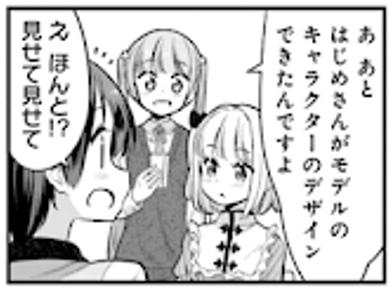

generated caption: 二人の女性が話し合っている様子が映っている
test_dataset\panel001\speech\speech1.PNG
text: ああとはじめさんがモデルのキャラクターのデザインできたんですよ
elapsed time: 32.99495244026184
translation: "Oh, and Hajime-san was able to design the character for the model."
test_dataset\panel001\speech\speech2.PNG
text: えほんと！？現せて見せて
elapsed time: 0.7286884784698486
pausing 19.27131152153015s before next api call
translation: "Really!? Show me, let me see it!"
Subdirectory: test_dataset\panel002


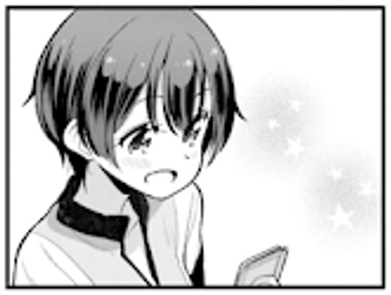

generated caption: 女性が手に持った携帯電話を見ている
Subdirectory: test_dataset\panel003


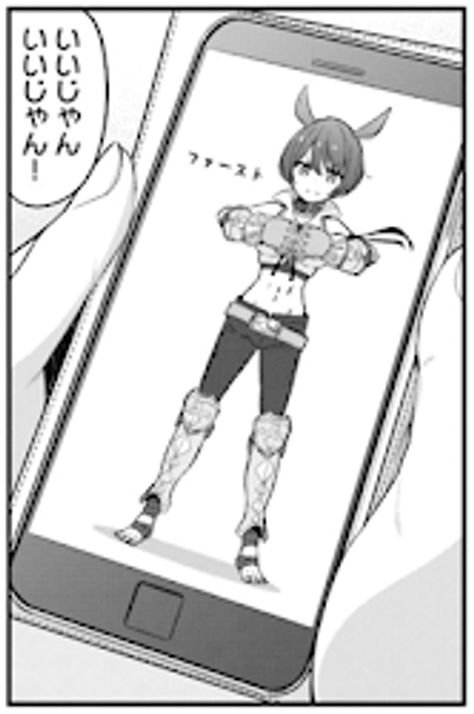

generated caption: 携帯電話を持っているアニメのポスター
test_dataset\panel003\speech\speech1.PNG
text: いいじゃんいいしゃん．．．
elapsed time: 53.30844235420227
translation: "It's fine, it's great to have a cellphone like this... "
Subdirectory: test_dataset\panel004


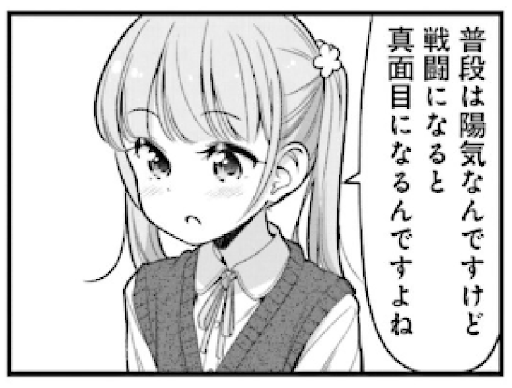

generated caption: ネクタイを締めた髪の長い女性の絵が飾ってある
test_dataset\panel004\speech\speech.png
text: 普段は陽気なんですけど戦闘になると真面目になろうですよね
elapsed time: 31.28185224533081
translation: "In general, I am cheerful, but when it comes to battles, I become serious, don't I?"


In [66]:
translate_manga(manga_directory='test_dataset')

## Useful Function to Create Directory Structure

In [2]:
import os
import math

def create_folders(directory: str, num_of_folders: int, digits: int):
    """
    Create multiple folders within a directory.
    
    Args:
    - directory: The path of the directory where folders will be created.
    - num_of_folders: The number of folders you want to make.
    """
    # Check if the directory exists, if not, create it
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # calculate the number of digits
    num_of_folders_digits = int(math.log10(num_of_folders))+1
    if num_of_folders_digits >= digits:
        digits = num_of_folders_digits
    
    # Create folders
    for i in range(1, num_of_folders + 1):
        # create manga panel folders
        panel_folder_name = f"panel{str(i).zfill(digits)}"
        panel_folder_path = os.path.join(directory, panel_folder_name)
        if not os.path.exists(panel_folder_path):
            os.makedirs(panel_folder_path)
            print(f"Folder '{panel_folder_name}' created successfully.")
        else:
            print(f"Folder '{panel_folder_name}' already exists.")
        
        # create the speech folder paths
        speech_folder_name = "speech"
        speech_folder_path = os.path.join(panel_folder_path, speech_folder_name)
        if not os.path.exists(speech_folder_path):
            os.makedirs(speech_folder_path)
            print(f"Speech folder in '{speech_folder_path}' created successfully.")
        else:
            print(f"Speech folder in '{speech_folder_path}' already exists.")

In [4]:
create_folders(directory="New_Game_Vol_11\Ch119", num_of_folders=60, digits=2)

Folder 'panel01' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel01\speech' created successfully.
Folder 'panel02' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel02\speech' created successfully.
Folder 'panel03' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel03\speech' created successfully.
Folder 'panel04' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel04\speech' created successfully.
Folder 'panel05' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel05\speech' created successfully.
Folder 'panel06' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel06\speech' created successfully.
Folder 'panel07' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel07\speech' created successfully.
Folder 'panel08' created successfully.
Speech folder in 'New_Game_Vol_11\Ch119\panel08\speech' created successfully.
Folder 'panel09' created successfully.
Speech folder in 'New_Gam

# Testing Manga109

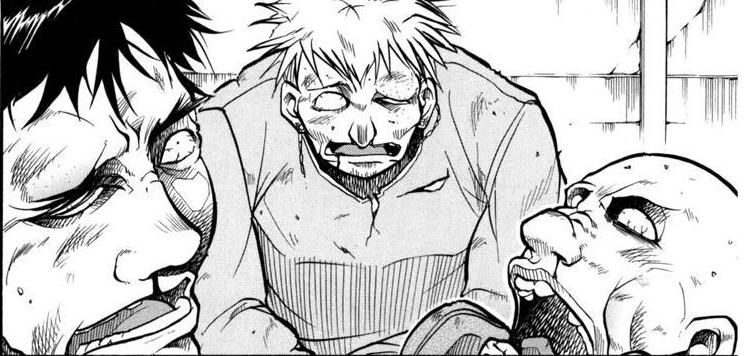

generated caption: 男性が人の口元に手を当てている
crop panel coords: 909.0, 2.0, 1653.0, 358.0
そこかっ！


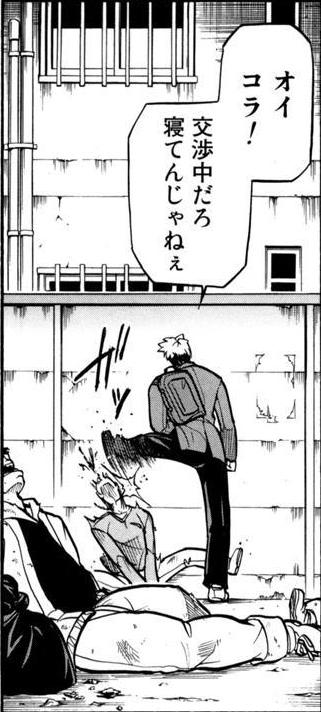

generated caption: 男性がスケボーに乗って倒れている
crop panel coords: 1267.0, 377.0, 1588.0, 1089.0


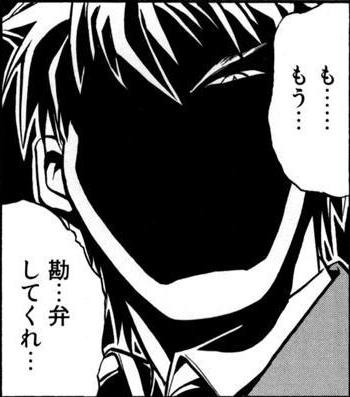

KeyboardInterrupt: 

In [10]:
import manga109api
from pprint import pprint
from PIL import Image, ImageDraw
from manga109utils import Book
import order_estimator


# (0) Instantiate a parser with the root directory of Manga109
manga109_root_dir = "Manga109_released_2023_12_07"
p = manga109api.Parser(root_dir=manga109_root_dir)


def draw_rectangle(img, x0, y0, x1, y1, annotation_type):
    assert annotation_type in ["body", "face", "frame", "text"]
    color = {"body": "#258039", "face": "#f5be41",
             "frame": "#31a9b8", "text": "#cf3721"}[annotation_type]
    draw = ImageDraw.Draw(img)
    draw.rectangle([x0, y0, x1, y1], outline=color, width=10)


book = "DualJustice"
page_index = 7
# pprint(annotation_ordered["page"][page_index])
annotation_ordered = p.get_annotation(book=book, separate_by_tag=True)
p = manga109api.Parser(root_dir=manga109_root_dir)
annotation = p.get_annotation(book=book, separate_by_tag=True)
img = Image.open(p.img_path(book=book, index=page_index))

# code to set up the panel order estimator
order_estimator.interception_ratio_threshold = 0.25
book_name = Book(book, manga109_root_dir=manga109_root_dir)

read_spch_bbls = []

def sort_key(spch_bbl):
    return spch_bbl['@ymax'], spch_bbl['@xmax']

# function that sorts all the speech bubbles and reads them in the correct order based on 
# a heuristic of their location on the page. 
def read_text(panel):
    found_spch_bbls = []  # speech bubbles that are in the panel go here
    for spch_bbl in annotation_ordered["page"][page_index]['text']:
        # check if the speech bubble is inside the panel
        if ((spch_bbl['@xmax'] <= panel.xmax) and (spch_bbl['@ymax'] <= panel.ymax) and (spch_bbl['@xmax'] >= panel.xmin) and (spch_bbl['@ymax'] >= panel.ymin)) or \
        ((spch_bbl['@xmin'] >= panel.xmin) and (spch_bbl['@ymin'] >= panel.ymin) and (spch_bbl['@xmin'] <= panel.xmax) and (spch_bbl['@ymin'] <= panel.ymax)):
            if spch_bbl['@id'] not in read_spch_bbls:
                read_spch_bbls.append(spch_bbl['@id'])
                found_spch_bbls.append(spch_bbl)
                # print(spch_bbl['#text'])
                # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")
    sorted_spch_bbls = sorted(found_spch_bbls, key=sort_key)
    for spch_bbl in sorted_spch_bbls:
        print(spch_bbl['#text'])
        # print(f"speech bubble coords: {spch_bbl['@xmin']}, {spch_bbl['@ymin']}, {spch_bbl['@xmax']}, {spch_bbl['@ymax']}")

for i_page, page in enumerate(book_name.get_page_iter()):
    if i_page != page_index:
        continue
    pagewidth = img.size[0]
    panels = page.get_bbs()["frame"]
    initial_cut = "two-page"
    boxOrderEstimator = order_estimator.BoxOrderEstimator(
        panels,
        pagewidth=pagewidth,
        initial_cut_option=initial_cut)

    for i_panel, panel in enumerate(boxOrderEstimator.ordered_bbs):
        order = i_panel + 1
        if len(panel.panels) == 1:
            # show_panel(panel, labeltext=f"{order}", edgecolor="red")
            cropped_panel = img.crop((panel.xmin, panel.ymin, panel.xmax, panel.ymax))
            cropped_panel.save(f"test_content/out.jpg")
            caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
            display(caption_generation_dataset[0]['raw'])
            
            # The caption_model.generate method returns the caption within a list as a string with spaces
            # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
            gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
            print(f"generated caption: {gen_caption}")
            
            print(f"crop panel coords: {panel.xmin}, {panel.ymin}, {panel.xmax}, {panel.ymax}")
            read_text(panel)

        else:
            print("looking at subpanels")
            for subpanel in panel.panels:
                # show_panel(subpanel, edgecolor="orange", linestyle="dotted", labeltext=f"({order})")
                cropped_panel = img.crop((subpanel.xmin, subpanel.ymin, subpanel.xmax, subpanel.ymax))
                cropped_panel.save(f"test_content/out.jpg")
                caption_generation_dataset = SampleDataset(f'test_content', visual_encoder['eval'])
                display(caption_generation_dataset[0]['raw'])
                # The caption_model.generate method returns the caption within a list as a string with spaces
                # to get the raw caption, we get the 0th item of the list and strip out the spaces with .replace(' ', '')
                gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
                print(f"crop panel coords: {subpanel.xmin}, {subpanel.ymin}, {subpanel.xmax}, {subpanel.ymax}")
                read_text(panel)
                    
# pprint(annotation["page"][page_index])

# for annotation_type in ["body", "face", "frame", "text"]:
# for annotation_type in ["frame"]:
#     rois = sorted(annotation["page"][page_index][annotation_type], key=lambda x: (x["@xmax"], x["@ymin"]))
#     for i, roi in enumerate(rois):
#         # draw_rectangle(img, roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"], annotation_type)
#         cropped_panel = img.crop((roi["@xmin"], roi["@ymin"], roi["@xmax"], roi["@ymax"]))
#         cropped_panel.save(f"test_content/out{i}.jpg")
#         text = annotation["page"][page_index]["text"][i]['#text']
#         print(f"out{i}.jpg: {text}")




img.save("out.jpg")

# Leftover Code from Testing

In [1]:
caption_generation_dataset = SampleDataset('./test_content', visual_encoder['eval'])
test_panel = "./test_content/mangapanel.png"

gen_caption = caption_model.generate(caption_generation_dataset[0])[0].replace(' ', '')
print(f"generated caption: {gen_caption}")
print(f"translated caption: {translator(gen_caption)}")
# normal panel
text = mocr(test_panel)
print(f"uncropped text: {text}")

trns_text = translator(text, max_length=max_len_limit)
print(f"trns_uncroptext{trns_text}")

# cropped panel
croptext = mocr("./test_content/mangapanelcrop.png")
print(f"normal_text: {croptext}")

final_text = gen_caption + "。" + croptext[:-1]

trns_croptext = translator(croptext, max_length=max_len_limit)
print(f"trns_croptext: {trns_croptext}")

print(f"final translated text: {translator(final_text, max_length=max_len_limit)}")

final_text_cont = "場面： "+ gen_caption + "。" + "登場人物の言ったこと： 「" + croptext[:-1] + "」"
print(f"finaler translated text: {translator(final_text_cont, max_length=max_len_limit)}")


NameError: name 'SampleDataset' is not defined

In [10]:
prompt = f"Translate this text to english: {final_text_cont}"
response = get_completion(prompt)
print(f"chatgpt translation: {response}")
time.sleep(api_constraints)

prompt = f"Translate this text to english: {final_text}"
response = get_completion(prompt)
print(f"chatgpt 2nd translation: {response}")
time.sleep(api_constraints)

prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the character from that same manga panel said: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 3rd translation: {response}")
time.sleep(api_constraints)

NameError: name 'final_text_cont' is not defined

In [36]:
gen_caption = "女性たちは登場人物の性格について読んで説明している。"
prompt = f"Here is the context of the scene of a manga panel: {gen_caption} And here is something that the girl from that same manga panel said about the character: {croptext} \nplease translate the character's words with this context in mind."
response = get_completion(prompt)
print(f"chatgpt 4th translation: {response}")
time.sleep(api_constraints)

chatgpt 4th translation: The girl from the manga panel said, "Normally, he's cheerful, but when it comes to battles, he becomes serious, right?"
